In [ ]:
!pip install transformers
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the IMDb dataset
df = pd.read_csv('IMDB Dataset.csv')

# Preprocessing: Convert labels to binary (0 for 'negative', 1 for 'positive')
df['binary_sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Split the data into training, validation, and testing sets
X = df['review'].values
y = df['binary_sentiment'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize and encode the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt', max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create DataLoader objects
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)



Epoch 1/5, Training Accuracy: 0.9659466666666666, Validation Accuracy: 0.89072


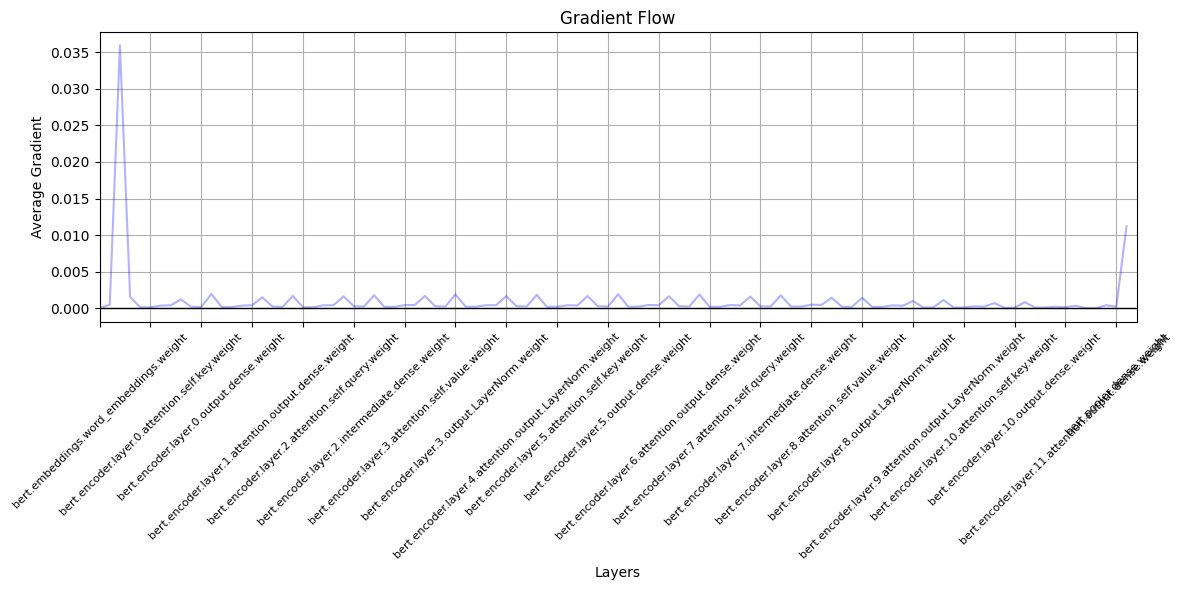

Epoch 2/5, Training Accuracy: 0.9826666666666667, Validation Accuracy: 0.89056


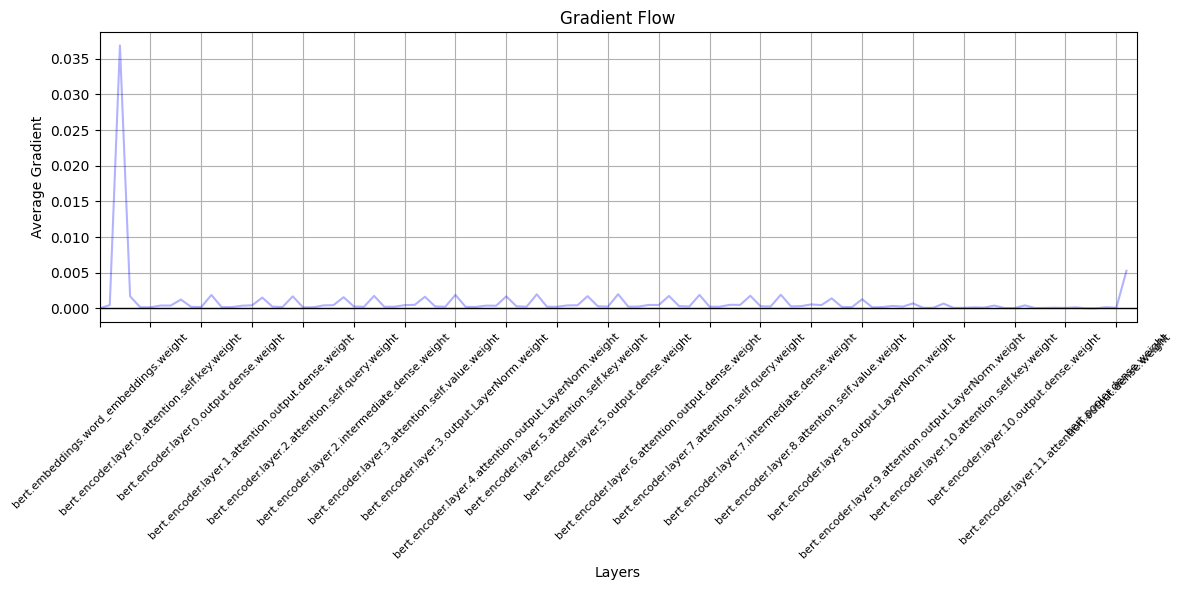

Epoch 3/5, Training Accuracy: 0.9887466666666667, Validation Accuracy: 0.8936


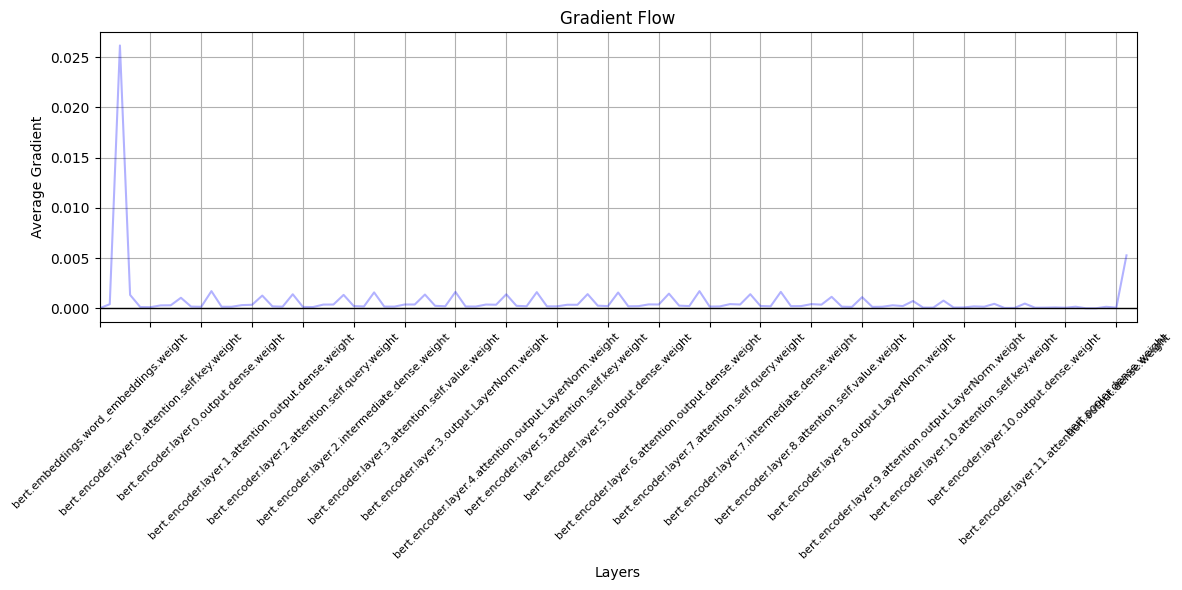

Epoch 4/5, Training Accuracy: 0.99112, Validation Accuracy: 0.89232


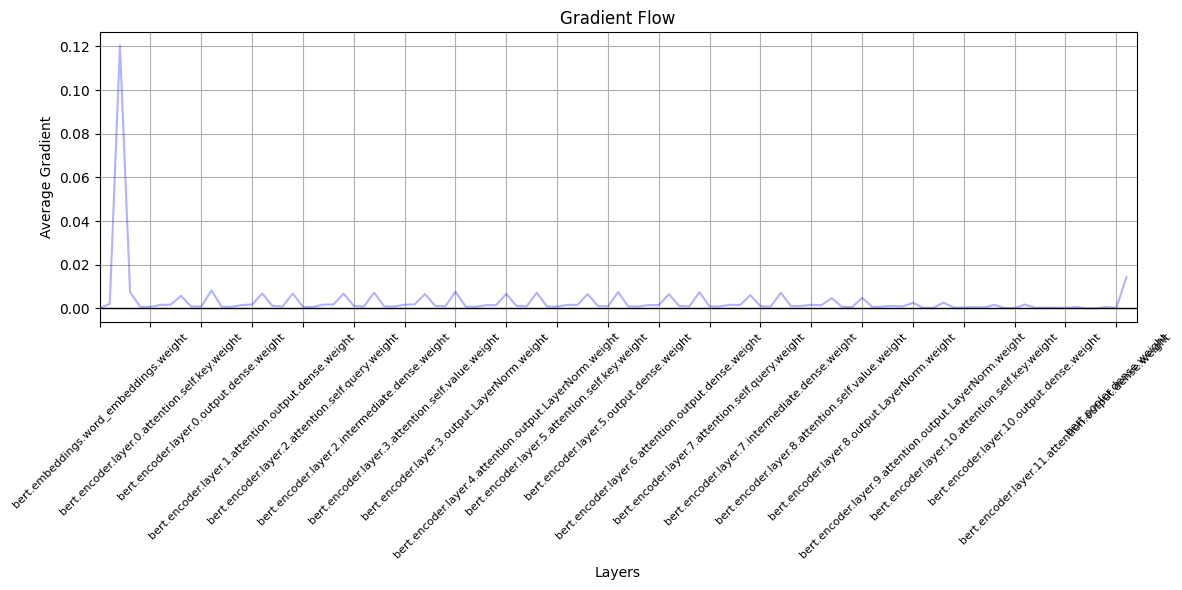

Epoch 5/5, Training Accuracy: 0.99264, Validation Accuracy: 0.89392


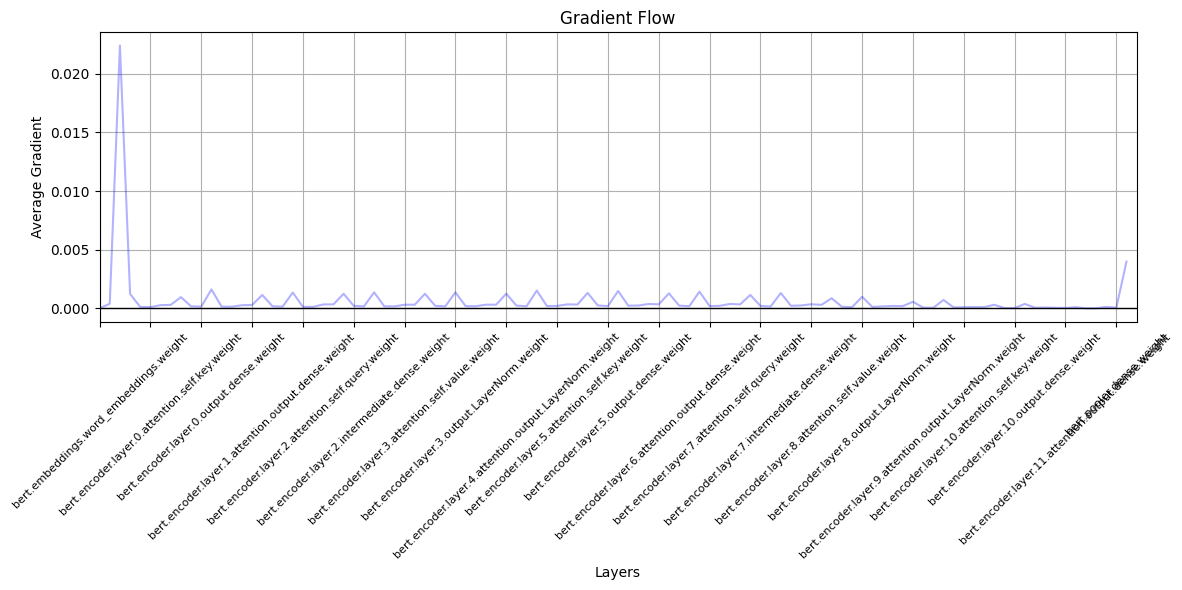

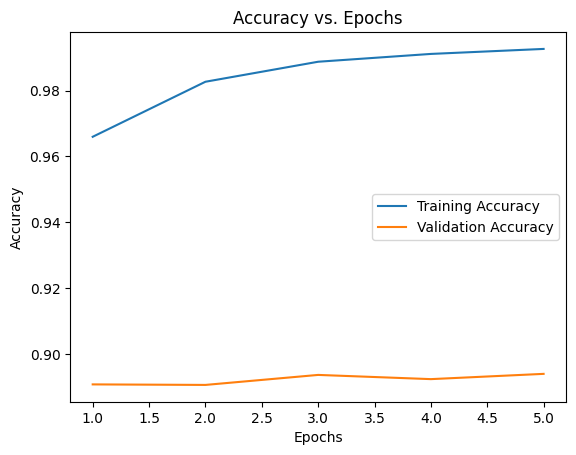

Test Accuracy: 0.89264


In [ ]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Setup for gradient visualization
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            if p.grad is not None:
                ave_grads.append(p.grad.abs().mean().cpu().numpy())
            else:
                ave_grads.append(0)
    plt.figure(figsize=(12, 6))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    # Only plot every 5th layer name for clarity
    plt.xticks(range(0, len(ave_grads), 5), layers[::5], rotation=45, fontsize=8)
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers", fontsize=10)
    plt.ylabel("Average Gradient", fontsize=10)
    plt.title("Gradient Flow", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 5  # You can adjust the number of epochs
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (torch.argmax(outputs.logits, dim=1) == labels).sum().item()
        total += labels.size(0)

        # Update the progress bar
        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': total_correct/total})

    # Calculate training accuracy for the current epoch
    train_accuracy = total_correct / total
    train_accuracies.append(train_accuracy)

    # Validate
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            total_correct += (torch.argmax(outputs.logits, dim=1) == labels).sum().item()
            total += labels.size(0)

    val_accuracy = total_correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

    # Visualize Gradient Flow
    plot_grad_flow(model.named_parameters())

# Plot Accuracy vs Epoch
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

# Evaluation on Test Set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")
